# Train VAE for task2...

This attemt uses reconstruction loss only, confirming model can be trained as usual Autoencoder.

Loss function is weighted as: $loss = L_{Reconstruction} + 0 L_{KLD} = L_{Reconstruction}$

In [1]:
# public modules
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)
from argparse import Namespace

# private modules
sys.path.append('..')
import common as com

from pytorch_common import *
from model import VAE, VAE_loss_function

# loading parameters -> hparams (argparse compatible)
params = EasyDict(com.yaml_load('config.yaml'))

# create working directory
ensure_folder(params.model_directory)

# test directories
dirs = com.select_dirs(param=params, mode='development')

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2020-03-16 10:24:14,132 - INFO - load_directory <- development


In [2]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6007 (pid 28384), started 1 day, 16:34:39 ago. (Use '!kill 28384' to kill it.)

In [3]:
# VAE Training class

class Task2VAELightning(Task2Lightning):

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, z, mu, logvar = self.model.forward_all(x)
        loss = VAE_loss_function(recon_x=y_hat, x=x, mu=mu, logvar=logvar,
                                 reconst_loss='mse',
                                 a_RECONST=1.,
                                 a_KLD=0.)   ############### No KLD loss this time --> Non variational, autoencoder
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}


# train models

for target_dir in dirs:
    target = str(target_dir).split('/')[-1]
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

    files = com.file_list_generator(target_dir)

    model = VAE(device, x_dim=params.VAE.x_dim, h_dim=params.VAE.h_dim, z_dim=params.VAE.z_dim).to(device)
    if target == 'ToyCar': summary(device, model)
    task2 = Task2VAELightning(device, model, params, files, normalize=True)
    trainer = pl.Trainer(max_epochs=10, # params.fit.epochs,  ###### Simple try --> short epochs
                         gpus=torch.cuda.device_count())
    trainer.fit(task2)
    
    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')

2020-03-16 10:25:02,849 - INFO - target_dir : dev_data/ToyConveyor
2020-03-16 10:25:02,854 - INFO - # of training samples : 3000


==== Start training [ToyConveyor] with 1 GPU(s). ====


2020-03-16 10:25:04,558 - INFO - Loading cached __cache_ToyConveyor_val.npy


2020-03-16 10:25:05,303 - INFO - Loading cached __cache_ToyConveyor_train.npy
2020-03-16 10:25:09,201 - INFO - Loading cached __cache_ToyConveyor_val.npy



saved ./model/model_ToyConveyor.pth.



## Visualize 

2020-03-16 10:29:33,534 - INFO - Loading cached __cache_ToyConveyor_train.npy


(1000, 640) (1000, 640)


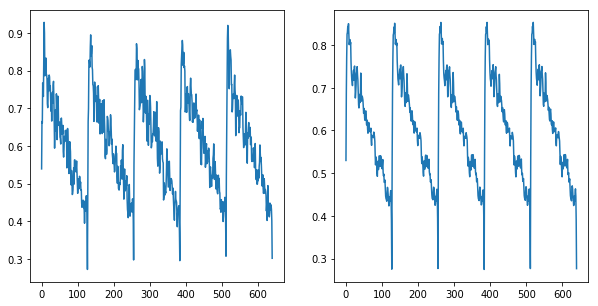

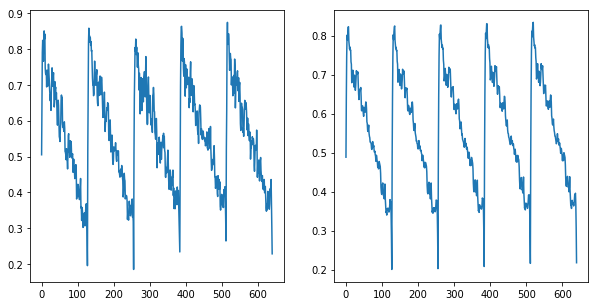

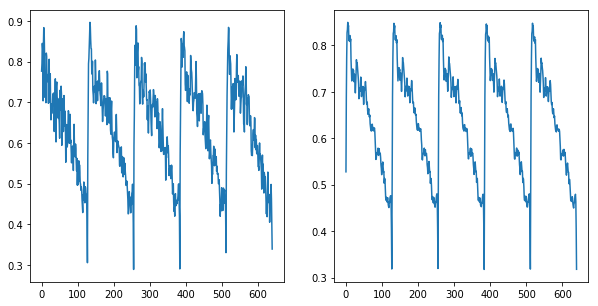

In [4]:
#load_weights(task2.model, 'model/model_ToyCar.pth')
show_some_predictions(task2.train_dataloader(), task2.model, 0, 3)

2020-03-16 10:29:37,964 - INFO - Loading cached __cache_ToyConveyor_val.npy


(1000, 640) (1000, 640)


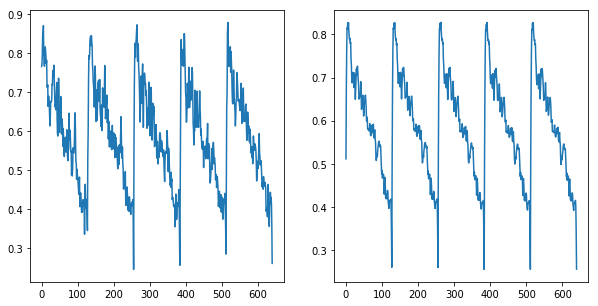

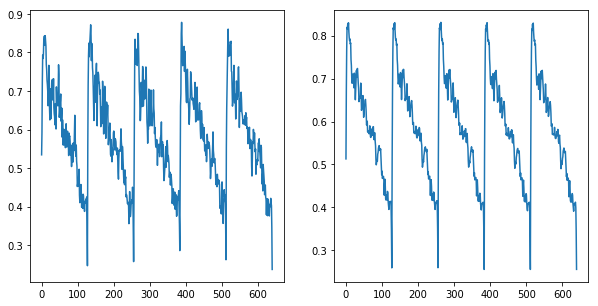

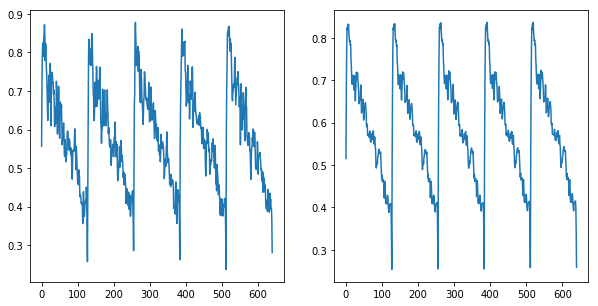

In [5]:
# Validation set samples
show_some_predictions(task2.val_dataloader(), task2.model, 0, 3)

## Check model weights

Weights for bottleneck variables looks reasonable. But mean (fc21.weight) is almost zero...

In [6]:
summarize_weights(task2.model)

,mean,std,min,max
fc11.weight,-0.002800,0.024245,-0.150377,0.160526
fc11.bias,-0.010091,0.029778,-0.162828,0.039186
fc12.weight,-0.001406,0.030307,-0.567937,0.483135
fc12.bias,-0.031552,0.054031,-0.202376,0.185485
fc21.weight,-0.001306,0.039120,-0.633266,0.639854
fc21.bias,0.021194,0.091762,-0.118280,0.173069
fc22.weight,-0.069531,0.232875,-1.941063,0.086256
fc22.bias,-0.030256,0.024391,-0.072130,0.019638
fc31.weight,-0.001367,0.136135,-0.600157,0.897530
fc31.bias,-0.021104,0.164125,-0.406047,0.344148


# Test the trained model

In [7]:
! python 01_test.py -d

2020-03-16 10:29:40,206 - INFO - load_directory <- development

[1/1] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/ToyConveyor
============== MODEL LOAD ==============
2020-03-16 10:29:40,207 - INFO - loading model: ./model/model_ToyConveyor.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         256,400
            Linear-2                  [-1, 400]         160,400
            Linear-3                   [-1, 20]           8,020
            Linear-4                   [-1, 20]           8,020
            Linear-5                  [-1, 400]           8,400
            Linear-6                  [-1, 400]         160,400
            Linear-7                  [-1, 640]         256,640
Total params: 858,280
Trainable params: 858,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [8]:
def upto_6digits(cell):
    if not cell[0].isdigit(): return cell
    return f'{float(cell):.6f}'

with open('result/result.csv') as f:
    for l in f.readlines():
        l = l.strip() #replace('\n', '')
        if ',' not in l:
            print(l)
            continue
        ls = l.split(',')
        print(f'{ls[0]}\t\t{upto_6digits(ls[1])}\t\t{upto_6digits(ls[2])}')

ToyConveyor
id		AUC		pAUC
01		0.707922		0.565033
02		0.597817		0.520589
03		0.648035		0.522578
Average		0.651258		0.536067

